In [42]:
import os
import pickle
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import json
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

In [43]:
markers = ['o', '*', 'v', '^', '<', 's']
sns.set_palette(palette=['#AC2C0C', '#495867','#577399','#BDD5EA','#3A7E5E','#B5CA8D'])
plt.rcParams.update({"text.usetex": True, "font.family" : "serif", "font.serif" : ["Computer Modern Serif"]})

In [126]:
models_textsc = {
    'baseline': '\\textsc{MBase}',
    'flex': '\\textsc{Flex}',
    'partflex-4.0': '\\textsc{PartFlex} ($\\mu = 4$)',
    'partflex-3.0': '\\textsc{PartFlex} ($\\mu = 3$)',
    'partflex-2.0': '\\textsc{PartFlex} ($\\mu = 2$)',
    'fixed': '\\textsc{Fixed}'
}

In [44]:
# Function to calculate the total demand
def calculate_total_demand(data):
    total_demand = 0
    scenarios = data['scenarios']
    for scenario in scenarios:
        for area_data in scenario['data']:
            total_demand += sum(area_data['demand'])
    return total_demand/data['num_scenarios']

In [45]:
# Load in files
directory = '../../raw_results'
file_names = os.listdir(directory)

results_df = pd.DataFrame()


results_file = f'{directory}/{file_names[0]}'
with open(results_file, 'rb') as file:
    sol = pickle.load(file)

In [46]:
# calculate couriers hired per period
couriers_weekday = np.zeros(8)
couriers_weekend = np.zeros(8)

for period in range(8):
    couriers_weekday[period] = sum((employee, area, period, day) in sol['k'] for employee, area, theta, day in sol['k'] if theta == period and day < 5)/5
    couriers_weekend[period] = sum((employee, area, period, day) in sol['k'] for employee, area, theta, day in sol['k'] if theta == period and day >= 5)/2

# Calculate couriers required per period
pattern = r'^(.+?)_OC'
base_name = re.search(pattern, file_names[0]).group(1)
weekday_path = f'../../instances/{base_name}_dt=doublepeak.json'
weekend_path = f'../../instances/{base_name}_dt=uniform.json'


# calculate period demand
required_couriers_weekday = np.zeros(8)
for scenario in weekday['scenarios']:
    for area_data in scenario['data']:
        for period in range(8):
            required_couriers_weekday[period] += area_data['required_couriers'][period]/weekday['num_scenarios']

required_couriers_weekend = np.zeros(8)
for scenario in weekend['scenarios']:
    for area_data in scenario['data']:
        for period in range(8):
            required_couriers_weekend[period] += area_data['required_couriers'][period]/weekend['num_scenarios']

# calculate difference in hired and required couriers
diff_weekday = couriers_weekday - required_couriers_weekday
diff_weekend = couriers_weekend - required_couriers_weekend

In [108]:
# Load in files
directory = '../../raw_results'
file_names = os.listdir(directory)

results_df = pd.DataFrame()

for i in range(len(file_names)):
    results_file = f'{directory}/{file_names[i]}'
    with open(results_file, 'rb') as file:
        sol = pickle.load(file)

    # Calculate number of total packages
    pattern = r'^(.+?)_OC'
    base_name = re.search(pattern, file_names[i]).group(1)
    weekday_path = f'../../instances/{base_name}_dt=doublepeak.json'
    weekend_path = f'../../instances/{base_name}_dt=uniform.json'

    with open(weekday_path, 'r') as file:
        weekday = json.load(file)

    with open(weekend_path, 'r') as file:
        weekend = json.load(file)

    weekend_demand = calculate_total_demand(weekend)
    weekday_demand = calculate_total_demand(weekday)
    total_demand = weekend_demand*2 + weekday_demand*5

    # Obtain baseline results
    keys_to_keep = ['city', 'demand_baseline', 'outsourcing_cost_multiplier', 'model', 'max_n_shifts', 'workforce_size']
    filtered_baseline = {key: sol['baseline'][key] for key in keys_to_keep}
    results_temp = pd.DataFrame(filtered_baseline)


    # Deal with region key inconsistency
    if 'region' in sol.keys():
        regions = sol['region']
    else:
        regions =  sol['regions']

    # Add the roster results
    wage_costs = sum( (employee, shift_start, day) in sol['r']
                    for region in regions 
                    for employee in sol['employees'][region]
                    for day in sol['days']
                    for shift_start in sol['shifts'][(region, day)])*4
    outsourcing_costs	= sol['obj_val'] - wage_costs

    results_temp['objective_value'] = sol['obj_val']
    results_temp['total_packages'] = total_demand
    results_temp['cost_per_package'] = results_temp['objective_value']/total_demand
    results_temp['objective_value_post_wage'] = outsourcing_costs
    results_temp['outsourcing_per_package'] = results_temp['objective_value_post_wage']/total_demand
    results_temp['wage_costs'] = wage_costs
    results_temp['wage_cost_per_package'] = results_temp['wage_costs']/total_demand
    results_temp['outsourcing_percentage'] = (results_temp['outsourcing_per_package'])/(results_temp['cost_per_package']*1.5)

    #############################
    # SURPLUS COURIERS
    #############################
    # duplicate row to store period by period results
    results_temp = pd.concat([results_temp]*8, axis=0, ignore_index=True)

    # Add weekend and period colum
    results_temp['period'] = list(range(8))
    
    # calculate couriers hired per period
    couriers_weekday = np.zeros(8)
    demand_weekday = np.zeros(8)
    couriers_weekend = np.zeros(8)
    demand_weekend = np.zeros(8)

    for period in range(8):
        couriers_weekday[period] = sum((employee, area, period, day) in sol['k'] for employee, area, theta, day in sol['k'] if theta == period and day < 5)/5
        couriers_weekend[period] = sum((employee, area, period, day) in sol['k'] for employee, area, theta, day in sol['k'] if theta == period and day >= 5)/2
        demand_weekday[period] = sum(area_data['required_couriers'][period] for scenario in weekday['scenarios'] for area_data in scenario['data'])/weekday['num_scenarios']
        demand_weekend[period] = sum(area_data['required_couriers'][period] for scenario in weekend['scenarios'] for area_data in scenario['data'])/weekend['num_scenarios']

    # calculate required couriers per period
    required_couriers_weekday = np.zeros(8)
    for scenario in weekday['scenarios']:
        for area_data in scenario['data']:
            for period in range(8):
                required_couriers_weekday[period] += area_data['required_couriers'][period]/weekday['num_scenarios']

    required_couriers_weekend = np.zeros(8)
    for scenario in weekend['scenarios']:
        for area_data in scenario['data']:
            for period in range(8):
                required_couriers_weekend[period] += area_data['required_couriers'][period]/weekend['num_scenarios']

    ## calculate difference in hired and required couriers
    surplus_couriers__weekday = couriers_weekday - required_couriers_weekday
    surplus_couriers__weekend = couriers_weekend - required_couriers_weekend

    # add to results
    for i in range(8):
        results_temp.at[i, 'surplus_couriers_weekday'] = surplus_couriers__weekday[i]
        results_temp.at[i, 'surplus_couriers_weekend'] = surplus_couriers__weekend[i]
        results_temp.at[i, 'demand_weekday'] = demand_weekday[i]
        results_temp.at[i, 'demand_weekend'] = demand_weekend[i]
        results_temp.at[i, 'required_couriers_weekday'] = required_couriers_weekday[i]
        results_temp.at[i, 'required_couriers_weekend'] = required_couriers_weekend[i]
        results_temp.at[i, 'couriers_weekday'] = couriers_weekday[i]
        results_temp.at[i, 'couriers_weekend'] = couriers_weekend[i]

    results_df = pd.concat([results_df, results_temp], axis=0, ignore_index=True)

# Fix model names
results_df['model'] = np.where(
    results_df['max_n_shifts'].notna() & (results_df['model'] != "baseline"),  # Condition to check non-null values
    results_df['model'] + '-' + results_df['max_n_shifts'].astype(str),  # True condition
    results_df['model']  # False condition, keep the original 'model'
)

In [109]:
results_df.head(14)

,city,demand_baseline,outsourcing_cost_multiplier,model,max_n_shifts,workforce_size,objective_value,total_packages,cost_per_package,objective_value_post_wage,...,outsourcing_percentage,period,surplus_couriers_weekday,surplus_couriers_weekend,demand_weekday,demand_weekend,required_couriers_weekday,required_couriers_weekend,couriers_weekday,couriers_weekend
0,berlin,0.5,1.8,partflex-3.0,3.0,80,2848.210000,3071.733333,0.927232,996.210000,...,0.233178,0,5.033333,0.500000,4.966667,37.500000,4.966667,37.500000,10.0,38.0
1,berlin,0.5,1.8,partflex-3.0,3.0,80,2848.210000,3071.733333,0.927232,996.210000,...,0.233178,1,-18.533333,2.566667,28.533333,35.433333,28.533333,35.433333,10.0,38.0
2,berlin,0.5,1.8,partflex-3.0,3.0,80,2848.210000,3071.733333,0.927232,996.210000,...,0.233178,2,2.566667,1.066667,49.433333,36.933333,49.433333,36.933333,52.0,38.0
3,berlin,0.5,1.8,partflex-3.0,3.0,80,2848.210000,3071.733333,0.927232,996.210000,...,0.233178,3,11.333333,2.600000,40.666667,35.400000,40.666667,35.400000,52.0,38.0
4,berlin,0.5,1.8,partflex-3.0,3.0,80,2848.210000,3071.733333,0.927232,996.210000,...,0.233178,4,12.300000,3.000000,39.700000,35.500000,39.700000,35.500000,52.0,38.5
5,berlin,0.5,1.8,partflex-3.0,3.0,80,2848.210000,3071.733333,0.927232,996.210000,...,0.233178,5,2.900000,3.233333,49.100000,35.266667,49.100000,35.266667,52.0,38.5
6,berlin,0.5,1.8,partflex-3.0,3.0,80,2848.210000,3071.733333,0.927232,996.210000,...,0.233178,6,-19.566667,4.166667,29.566667,34.333333,29.566667,34.333333,10.0,38.5
7,berlin,0.5,1.8,partflex-3.0,3.0,80,2848.210000,3071.733333,0.927232,996.210000,...,0.233178,7,6.000000,3.333333,4.000000,35.166667,4.000000,35.166667,10.0,38.5
8,paris,1.0,1.5,partflex-3.0,3.0,198,5896.088098,15578.866667,0.378467,1532.088098,...,0.173232,0,33.933333,9.433333,11.066667,63.566667,11.066667,63.566667,45.0,73.0
9,paris,1.0,1.5,partflex-3.0,3.0,198,5896.088098,15578.866667,0.378467,1532.088098,...,0.173232,1,-4.433333,9.733333,49.433333,63.266667,49.433333,63.266667,45.0,73.0


In [110]:
# Calculate period level average surplus couriers
surplus_couriers = results_df.groupby(['period', 'model'])[['surplus_couriers_weekday', 'surplus_couriers_weekend','required_couriers_weekday','required_couriers_weekend','couriers_weekday', 'couriers_weekend']].mean().reset_index()
surplus_couriers

,period,model,surplus_couriers_weekday,surplus_couriers_weekend,required_couriers_weekday,required_couriers_weekend,couriers_weekday,couriers_weekend
0,0,fixed,81.051754,12.635526,10.069298,59.246053,91.121053,71.881579
1,0,flex,29.809649,9.832895,10.069298,59.246053,39.878947,69.078947
2,0,partflex-2.0,74.918222,12.282222,9.871111,56.917778,84.789333,69.200000
3,0,partflex-3.0,27.670222,9.768889,9.871111,56.917778,37.541333,66.686667
4,0,partflex-4.0,27.608889,9.782222,9.871111,56.917778,37.480000,66.700000
5,1,fixed,44.683772,13.071053,46.437281,58.810526,91.121053,71.881579
6,1,flex,-6.268860,10.248684,46.437281,58.810526,40.168421,69.059211
7,1,partflex-2.0,40.018222,12.742222,44.771111,56.457778,84.789333,69.200000
8,1,partflex-3.0,-6.933778,10.222222,44.771111,56.457778,37.837333,66.680000
9,1,partflex-4.0,-7.000444,10.208889,44.771111,56.457778,37.770667,66.666667


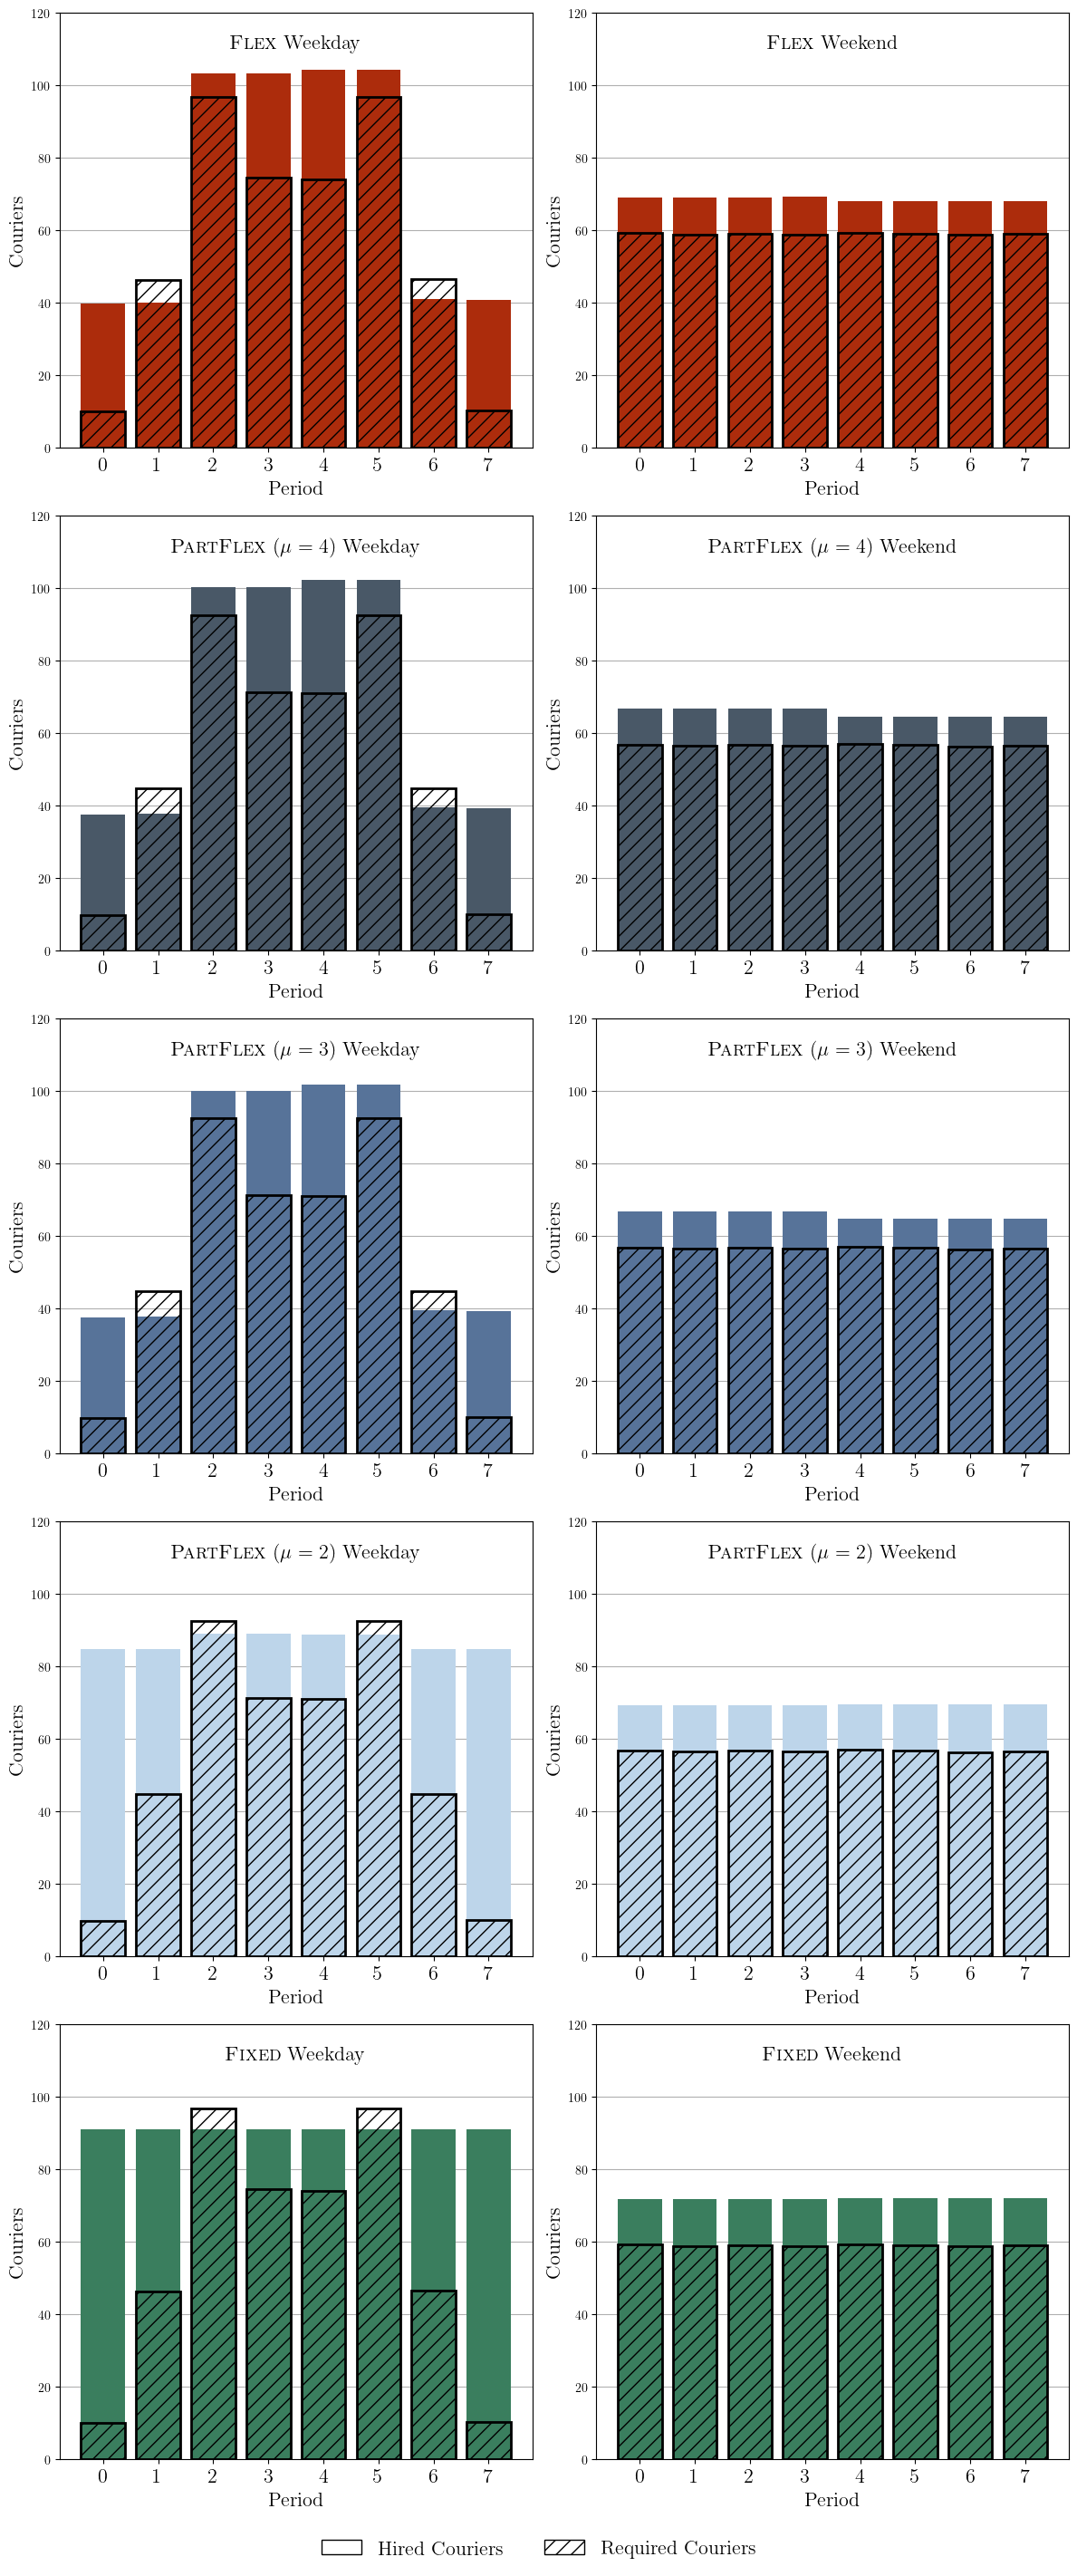

In [147]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming surplus_couriers DataFrame is already defined

models = ['flex', 'partflex-4.0', 'partflex-3.0', 'partflex-2.0', 'fixed']

def plot_hired_vs_required_for_models(models):
    fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(12, 6 * len(models)))

    for i, model in enumerate(models):
        data = surplus_couriers[surplus_couriers['model'] == model]
        
        # Weekday
        ax = axes[i, 0]
        ax.bar(
            x=data['period'],
            height=data['couriers_weekday'],
            color=f'C{i}',
            linewidth=2,
            edgecolor=None
        )
        ax.bar(
            x=data['period'],
            height=data['required_couriers_weekday'],
            color="none",
            linewidth=2,
            edgecolor="black",
            hatch='//'
        )
        ax.set_ylim((0, 120))
        ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
        ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7], fontsize=16)
        ax.set_ylabel('Couriers', fontsize=16)
        ax.yaxis.grid(which='major')
        ax.axes.set_axisbelow(True)
        ax.set_xlabel('Period', fontsize=16)
        ax.text(0.5, 0.95, f'{models_textsc[model]} Weekday', fontsize=16, ha='center', va='top', transform=ax.transAxes)


        # Weekend
        ax = axes[i, 1]
        ax.bar(
            x=data['period'],
            height=data['couriers_weekend'],
            color=f'C{i}',
            linewidth=2,
            edgecolor=None
        )
        ax.bar(
            x=data['period'],
            height=data['required_couriers_weekend'],
            color="none",
            linewidth=2,
            edgecolor="black",
            hatch='//'
        )
        ax.set_ylim((0, 120))
        ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
        ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7], fontsize=16)
        ax.set_ylabel('Couriers', fontsize=16)
        ax.yaxis.grid(which='major')
        ax.axes.set_axisbelow(True)
        ax.set_xlabel('Period', fontsize=16)
        ax.text(0.5, 0.95, f'{models_textsc[model]} Weekend', fontsize=16, ha='center', va='top', transform=ax.transAxes)


    # Create custom legend patches
    patches = [
        Patch(facecolor='none', edgecolor='black', label='Hired Couriers'),
        Patch(facecolor='none', edgecolor='black', hatch='//', label='Required Couriers')
    ]

    # Add the global legend
    fig.legend(handles=patches, loc='lower center', ncol=2, frameon=False, fontsize=16)

    fig.subplots_adjust(top=1, bottom=0.1)  # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0.02, 1, 0.95])  # Leave space for legend

    plt.show()

    fig.savefig('figures/surplus_couriers.pdf', bbox_inches='tight', dpi=100)

plot_hired_vs_required_for_models(models)


In [103]:
def plot_courier_surplus():
  
    models = ['flex', 'partflex-4.0', 'partflex-3.0', 'partflex-2.0', 'fixed']

    fig, ax = plt.subplots(figsize=(10,6))

    data = surplus_couriers[surplus_couriers['model'] == 'fixed']

    # Barplot
    colors = [f'C{4}' if val >= 0 else f'C{0}' for val in data['surplus_couriers_weekday']]
    ax.bar(
        x=data['period'],
        height=data['surplus_couriers_weekday'],
        color=colors ,
        linewidth=2,
        edgecolor=None
    )

    ax.set_ylim((data['surplus_couriers_weekday'].min() - 50, data['surplus_couriers_weekday'].max() + 50))
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
    ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7], fontsize=16)
    ax.set_ylabel('Surplus Couriers', fontsize=16)
    ax.yaxis.grid(which='major')
    ax.axes.set_axisbelow(True)
    ax.set_xlabel('Period', fontsize=16)

    fig.tight_layout()
    #fig.savefig('figures/shift_ov.pdf', dpi=96, bbox_inches='tight')

    return fig, ax

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Period', ylabel='Surplus Couriers'>)

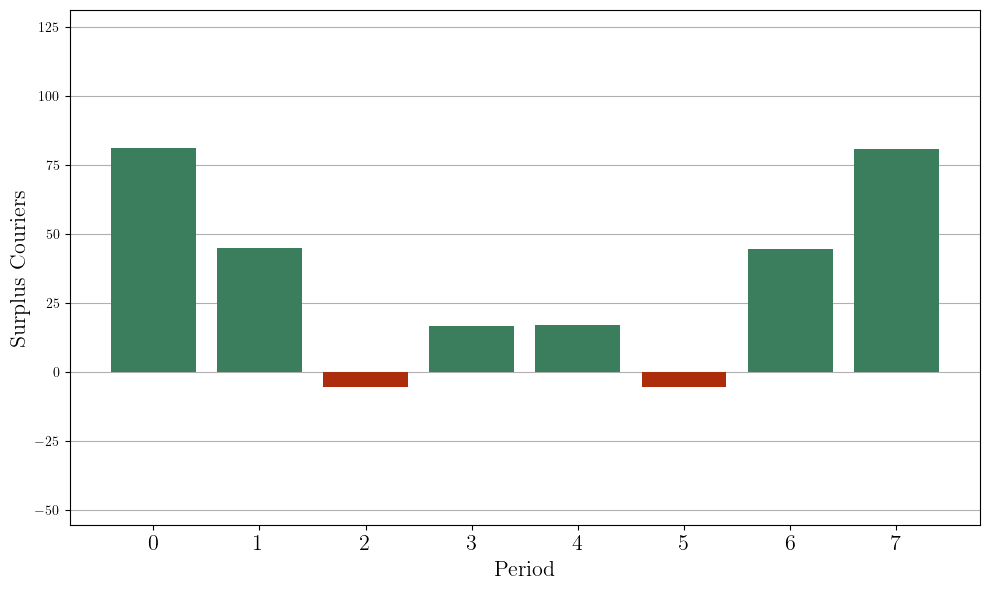

In [104]:
plot_courier_surplus()